In [1]:

import numpy as np
import matplotlib.pyplot as plt
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
import corner

import starry

from ttv2fast2furious import MultiplanetSystemBasisFunctionMatrices
from ttv2fast2furious import MultiplanetSystemLinearModelAmplitudes
import ttv2fast2furious

In [2]:
# fake planet params

params = {
    "m_b": 9.01e-5, # solar mass
    "p_b": 5.0, # days
    "e_b": 0.0, # eccentricity
    "vp_b": 0.0, # varpi
    "t0_b": 8.0, # days
    "r_b": 0.083, # rp/r*
    "b_b": 0.3, # impact
    
    "m_c": 6.01e-4,
    "p_c": 10.1,
    "e_c": 0.005,
    "vp_c": 0.0,
    "t0_c": 1.0,
    "r_c": 0.124,
    "b_c": 0.3, 
}


In [3]:
timearr = np.array([])
modarr = np.array([])

#ttimes = [[8.02854959670312, 13.034148151747647], [0.9992974990139601, 11.099177490742177]]


ttimes = [[8.02854959670312, 
           13.034148151747647, 
           18.03350406730311, 
           23.038633236327943, 
           28.037939112460965, 
           33.04254088760791, 
           38.04178566849486, 
           43.045811460828595, 
           48.044983499940756, 
           53.048395021282275, 
           58.04748213101699, 
           63.05025209360869, 
           68.04924163486709, 
           73.05135425296186, 
           78.0502332698979, 
           83.05168454919219, 
           88.05043995531831, 
           93.0512377576998, 
           98.04985658110013], 
          
          [0.9992974990139601, 
           11.099177490742177, 
           21.199066579369486, 
           31.298966276796612, 
           41.39887808075423, 
           51.49880346456791, 
           61.59874386408817, 
           71.698700661679, 
           81.79867516721151, 
           91.89866859603794]]


# get time values
tval=np.arange(0,100.0,0.00138)
#tval=np.arange(0,15.0,0.00138)

# parameters for both planets
impacts = np.array([params["b_b"], params["b_c"]])
rs = np.array([params["r_b"], params["r_c"]])

# create TTVOrbit, only with lists of transit times
orb = xo.orbits.TTVOrbit(transit_times=ttimes, b=impacts, rhostar=1.5)

# limb darkening coefficients
u = [0.2, 0.4]

# light curve synthesis
tmod = xo.StarryLightCurve(u).get_light_curve(orbit=orb, r=rs, t=tval, texp=0.00138).eval()
tmod = tmod.flatten()

# time and flux
timearr = tval
modarr = tmod

/Users/jbrande/miniconda2/envs/exoplanet/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [4]:

time = timearr/2. 
modarr = modarr[0:len(timearr)]
flux = (modarr+np.random.normal(0, 0.001, len(modarr)))*1e3

50.0
[10.  5.]


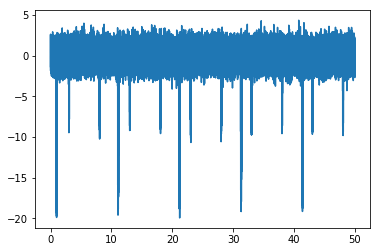

In [5]:

plt.plot(time, flux)

# some utilities: get total lightcurve length in days, get number of each planet transits
len_x = round(time.max() - time.min())
n_b = round((round(time.max() - time.min())) / params["p_b"])
n_c = round((round(time.max() - time.min())) / params["p_c"])

num_transits = np.array([n_b, n_c])

num_planets = 2

print(len_x)
print(num_transits)


In [6]:
x = time
y = flux
texp = 0.00138 # TESS 2min cadence

guess_p_period = np.array([params["p_b"], params["p_c"]])
guess_p_t0 = np.array([params["t0_b"], params["t0_c"]])
depth = np.array([params["r_b"], params["r_c"]])**2
logw0_guess =  np.log(2*np.pi/50)
ror_guess = np.array([params["r_b"], params["r_c"]])
eccs = np.array([params["e_b"], params["e_c"]])

def build_model(mask=None, start=None):

    if mask is None:
        print("making mask")
        mask = np.ones(len(x), dtype=bool)
    else:
        print("not making mask")
    with pm.Model() as model:
        mean = pm.Normal("mean", mu=0.0, sd=2.0)
        u_star = xo.distributions.QuadLimbDark("u_star", testval=np.array([0.2, 0.4]))
        
        logs2 = pm.Normal("logs2", mu=np.log(0.5*np.std(y[mask])), sd=2.0)
        
        logw0 = pm.Normal("logw0", mu=logw0_guess, sd=10)
        logpower = pm.Normal("logpower", mu=np.log(0.5 *np.var(y[mask]))+4*logw0_guess, sd=10)
        logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
        
        kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        
        R_star = 1.0, 0.05
        Rho_star = 1.5
        r_star = pm.Normal("r_star", mu=R_star[0], sd=R_star[1])
        logrho_star = pm.Normal("logrho_star", mu=np.log(Rho_star), sd=0.3)
        rho_star = pm.Deterministic("rho_star", tt.exp(logrho_star))
        pm.Potential("r_star_prior", tt.switch(r_star > 0, 0, -np.inf))
        
        # Orbital parameters for the planets
        
        # fix period, t0 because we probably know them pretty well
        period = guess_p_period
        t0 = guess_p_t0
        
        logror = np.log(ror_guess)#0.15945)
        ror = pm.Deterministic("r", tt.exp(logror))
        r_pl = pm.Deterministic("r_pl", r_star * ror)
        r_ple = pm.Deterministic("r_ple", (r_star * ror / 0.009155))
        b = xo.distributions.UnitUniform("b", shape=1, testval=0.1)

        ecc = 0
        omega = 0
        
        light_curve = np.zeros_like(x[mask])
        
        # (hopefully) multidimensional ttv variable
        # DFM says use lists of normals, so try that

        guesses_b = []
        guesses_c = []
        
        tmp = guess_p_t0[0]
        for i in range(int(num_transits[0])):
            guesses_b.append(tmp)
            tmp = tmp + guess_p_period[0]
        #guesses_b = np.array(guesses_b)
        
        tmp = guess_p_t0[1]
        for i in range(int(num_transits[1])):
            guesses_c.append(tmp)
            tmp = tmp + guess_p_period[1]
        #guesses_c = np.array(guesses_c)
        
        # np.ones(int(num_transits[0]))*0.25
        #times = np.array([
        #    pm.Normal("t_b", mu=guesses_b, sd=(np.ones(int(num_transits[0]))*0.25), shape=(int(num_transits[0]))),
        #    pm.Normal("t_c", mu=guesses_c, sd=(np.ones(int(num_transits[1]))*0.25), shape=(int(num_transits[1]))),
        #])
        
        ttvs = np.array([
            pm.Normal("ttv_b", mu=np.zeros(int(num_transits[0])), sd=0.25*np.ones(int(num_transits[0])), shape=int(num_transits[0])),
            pm.Normal("ttv_c", mu=np.zeros(int(num_transits[1])), sd=0.25*np.ones(int(num_transits[1])), shape=int(num_transits[1])),
        ])

        ror_mod = ror
        r_pl_mod = ror_mod * r_star
        
        print("making orbit")
        # use either transit times, or ttvs + period
        #orbit = xo.orbits.TTVOrbit(r_star=r_star, rho_star=rho_star, transit_times=times, b=b, ecc=ecc, omega=omega)
        orbit = xo.orbits.TTVOrbit(r_star=r_star, rho_star=rho_star, ttvs=ttvs, period=guess_p_period, t0=guess_p_t0, b=b, ecc=ecc, omega=omega)
        
        print("making lightcurves")
        ### This command kills the kernel for some reason
        light_curves = xo.LimbDarkLightCurve(u_star).get_light_curve(orbit=orbit, r=r_pl_mod, t=x, texp=texp, use_in_transit=True)*1e3
        
        
        
        print("making second lightcurve")
        light_curve = pm.math.sum(light_curves, axis=-1) + mean
        
        print("made orbit, made light curves")
        
        print("optimizing")
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[logs2])
        map_soln = xo.optimize(start=map_soln, vars=[b])
        #map_soln = xo.optimize(start=map_soln, vars=[ttvs])
        map_soln = xo.optimize(start=map_soln, vars=[u_star])
        map_soln = xo.optimize(start=map_soln, vars=[mean, logs2, logrho_star, u_star, b])
        map_soln = xo.optimize(start=map_soln, vars=[logw0, logpower])

    return model, map_soln

In [ ]:
model0, map_soln0 = build_model()

making mask
making orbit
making lightcurves


0.04631175107380067


INFO (theano.gof.compilelock): Refreshing lock /Users/jbrande/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.6.4-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /Users/jbrande/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.6.4-64/lock_dir/lock


0.036803296254869874
0.038734455657387784
0.0392098340121471
0.044101333581844815
0.03993355790208116
0.04698606422065381
0.04681633798008266
0.04863982743868634
0.04721977782281133
0.05396778871011165
0.050534424788500114
0.05061562478198367
0.04905330388989349
0.05177311466034946
0.04950848994729537
0.052441000113921055
0.04267888678223464


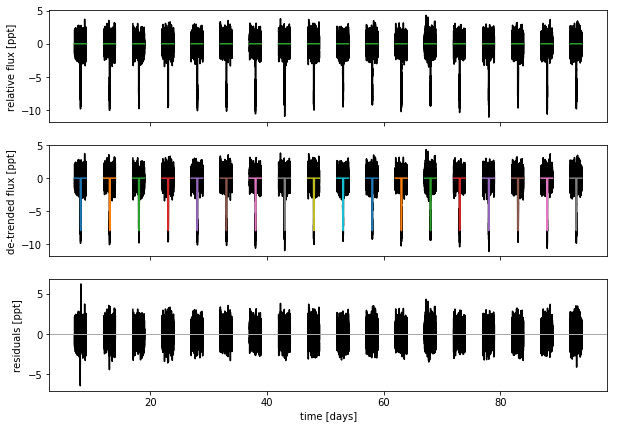

In [158]:
def plot_light_curve(model, soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    
    
    for i in range(ntransits):
        print(soln["ttv_{}".format(i)])
        maskt = ((x > guess_p_t0 + (guess_p_period*i) - thwindow) * 
                     (x < guess_p_t0 + (guess_p_period*i) + thwindow))
        mask1 = maskt * mask
        ax = axes[0]
        ax.plot(x[mask1], y[mask1], "k", label="data")
        gp_mod = np.zeros_like(x[mask1])
        gp_mod += soln["mean"]
        ax.plot(x[mask1], gp_mod, color="C2", label="gp model")
#         ax.legend(fontsize=10)
        ax.set_ylabel("relative flux [ppt]")

        ax = axes[1]
        ax.plot(x[mask1], y[mask1] - gp_mod, "k", label="de-trended data")
        light_curves = xo.utils.eval_in_model(model.named_vars['light_curve_{}'.format(i)],
                                              soln, model=model)

        mod = light_curves
        ax.plot(x[mask1], mod, label="planet {0}".format(i))
#         ax.legend(fontsize=10)
        ax.set_ylabel("de-trended flux [ppt]")

        ax = axes[2]
        mod = gp_mod + light_curves
        ax.plot(x[mask1], y[mask1] - mod, "k")
        ax.axhline(0, color="#aaaaaa", lw=1)
        ax.set_ylabel("residuals [ppt]")
#         ax.set_xlim(x[mask1].min(), x[mask1].max())
        ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(model0, map_soln0);

In [160]:
model = model0
map_soln = map_soln0

In [161]:
# need to run sampler


np.random.seed(90210)
sampler = xo.PyMC3Sampler(start=200, window=100, finish=500, chains=4)
# sampler = xo.PyMC3Sampler()
with model:
    burnin = sampler.tune(tune=3500, start=map_soln,
                          step_kwargs=dict(target_accept=0.9))

INFO (theano.gof.compilelock): Refreshing lock /Users/jbrande/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.6.4-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /Users/jbrande/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.6.4-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/jbrande/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.6.4-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /Users/jbrande/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.6.4-64/lock_dir/lock
/Users/jbrande/miniconda2/envs/exoplanet/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sampling 4 chains: 100%|█

In [163]:
with model:
    trace = sampler.sample(draws=3000)

Sampling 4 chains: 100%|██████████| 12000/12000 [53:29<00:00,  3.74draws/s] 
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
There were 101 divergences after tuning. Increase `target_accept` or reparameterize.
There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
There were 95 divergences after tuning. Increase `target_accept` or reparameterize.


In [164]:
varnames = ['mean',
 'logs2',
 'r_star',
 'logrho_star',
 'u_star',
 'rho_star',
 'r_pl',
 'r_ple',
 'b',]

for name in map_soln:
    #print(name)
    if name[0:4] == "ttv_":
        varnames.append(name)

pm.summary(trace, varnames=varnames)

/Users/jbrande/miniconda2/envs/exoplanet/lib/python3.6/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,-0.010169,0.006520,0.000066,-0.023036,0.002252,11484.995584,0.999861
logs2,0.007163,0.009001,0.000085,-0.010043,0.025301,10263.261300,0.999951
r_star,0.998705,0.050503,0.000429,0.898026,1.097691,12169.154948,1.000207
logrho_star,0.267513,0.050844,0.000889,0.166834,0.366697,2958.090051,1.000052
logP__0,1.610274,0.000471,0.000004,1.609318,1.611158,11012.996901,0.999921
u_star__0,0.140345,0.073016,0.000889,0.000397,0.264875,4056.302057,1.000045
u_star__1,0.524913,0.117104,0.001486,0.303293,0.737765,3804.769767,1.000036
rho_star,1.308401,0.066578,0.001173,1.181558,1.442961,2897.919332,1.000056
r_pl,0.082893,0.004192,0.000036,0.074536,0.091108,12169.154948,1.000207
r_ple,9.054345,0.457865,0.003887,8.141575,9.951758,12169.154948,1.000207


/Users/jbrande/miniconda2/envs/exoplanet/lib/python3.6/site-packages/pymc3/plots/__init__.py:40: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1b1972908>,
      dtype=object)

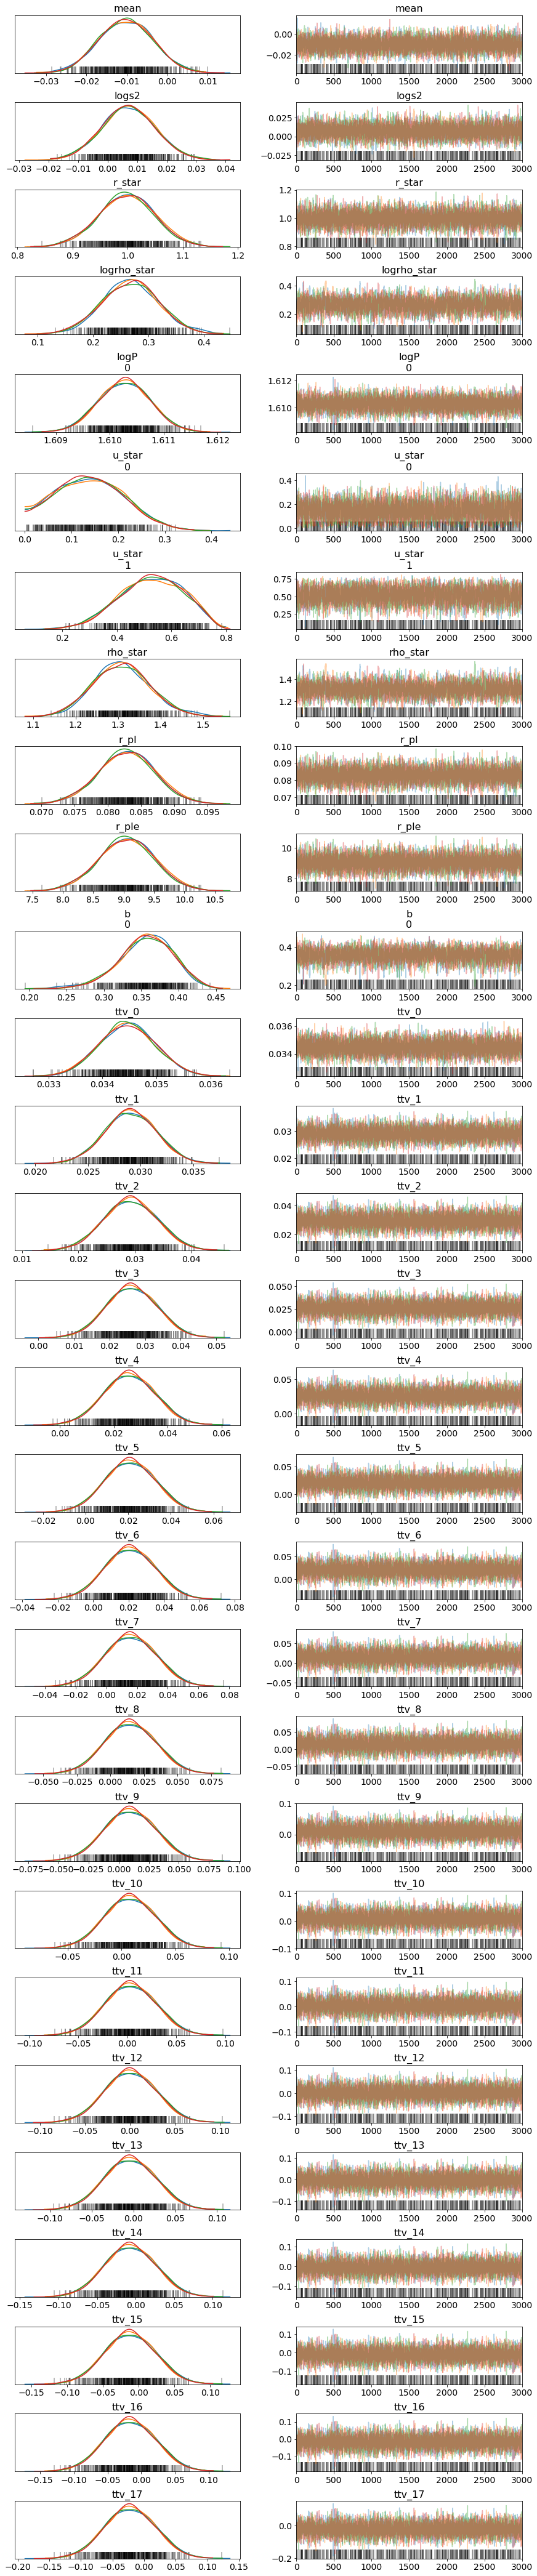

In [165]:
pm.traceplot(trace, varnames=varnames)

49.62431812156187 0.7328247735571106
41.875266732010836 3.4589604131746645
42.16995755192994 6.799138487105048
37.797663063380746 10.211185144388896
37.211916462414536 13.609980642983258
30.24237680279874 16.98799866385468
30.040962734315876 20.37778737443648
22.93596225867287 23.77838999034544
21.249895893627315 27.16305095151514
13.988379227152086 30.570482507365607
11.72046557962496 33.954542863797
5.122210153486767 37.3591894234331
1.2020457615013895 40.76856294177544
-5.266984411823501 44.15228622268557
-9.657893285654515 47.54673664109676
-16.97096753348334 50.93556779344931
-23.353194772129743 54.328172783531734
-31.258147183970365 57.73958292946148


Text(0, 0.5, 'TTV')

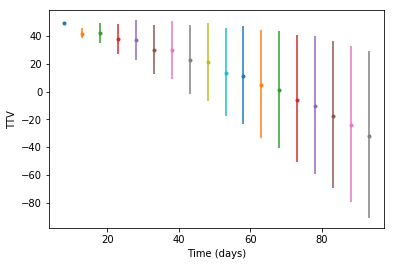

In [169]:
for i in range(ntransits):
    print(np.mean(trace["ttv_{}".format(i)])*24*60, np.std(trace["ttv_{}".format(i)])*24*60)
    #t = np.mean(trace['t0'] + (np.exp(trace['logP']) * i))
    t = np.mean(guess_p_t0 + (np.exp(trace['logP']) * i))
    v = np.percentile(trace['ttv_{}'.format(i)]*24*60, [15, 50, 85])
    plt.errorbar(t, v[1], yerr=[[v[1]-v[0]], [v[2]-v[1]]], fmt='.')
    #plt.scatter(t, v[1])#, yerr=[[v[1]-v[0]], [v[2]-v[1]]], fmt='.')
plt.xlabel('Time (days)')
plt.ylabel('TTV')

/Users/jbrande/miniconda2/envs/exoplanet/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


t0s
ttvs
66.68892154627297
52.99674660701262
55.77761614663841
56.46216097749183
63.50592035785653
57.50432337899687
67.65993247774148
67.41552669131903
70.04135151170833
67.99648006484831
77.71361574256078
72.76957169544016
72.88649968605648
70.63675760144663
74.55328511090322
71.29222552410533
75.51504016404633
61.45759696641788


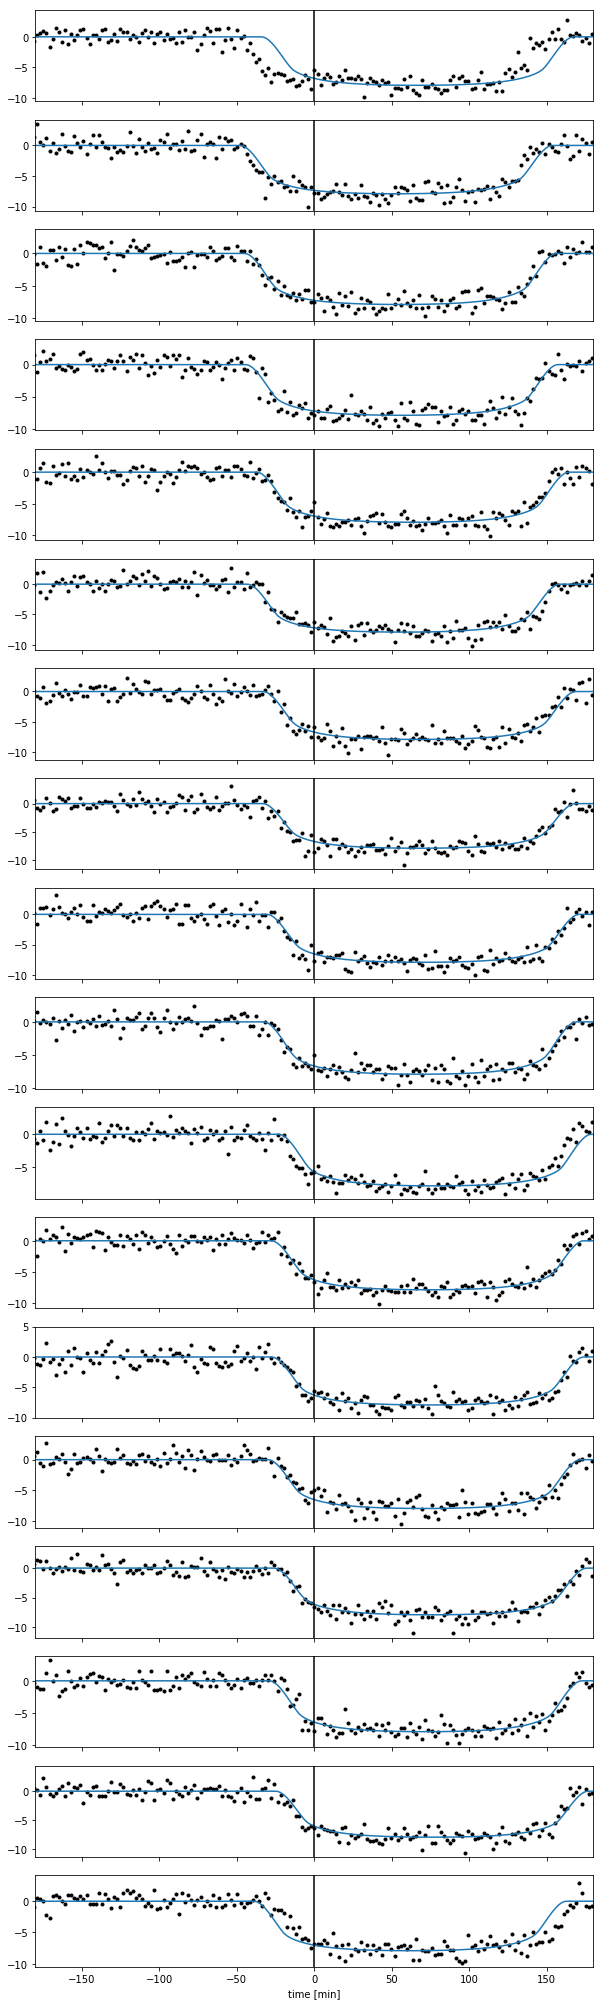

In [170]:
stack_transits(model, map_soln)

In [171]:
import corner

In [172]:
vs = []
for name in trace.varnames:
    if name[:3] == "ttv":
        vs.append(name)
print(vs)

['ttv_0', 'ttv_1', 'ttv_2', 'ttv_3', 'ttv_4', 'ttv_5', 'ttv_6', 'ttv_7', 'ttv_8', 'ttv_9', 'ttv_10', 'ttv_11', 'ttv_12', 'ttv_13', 'ttv_14', 'ttv_15', 'ttv_16', 'ttv_17']


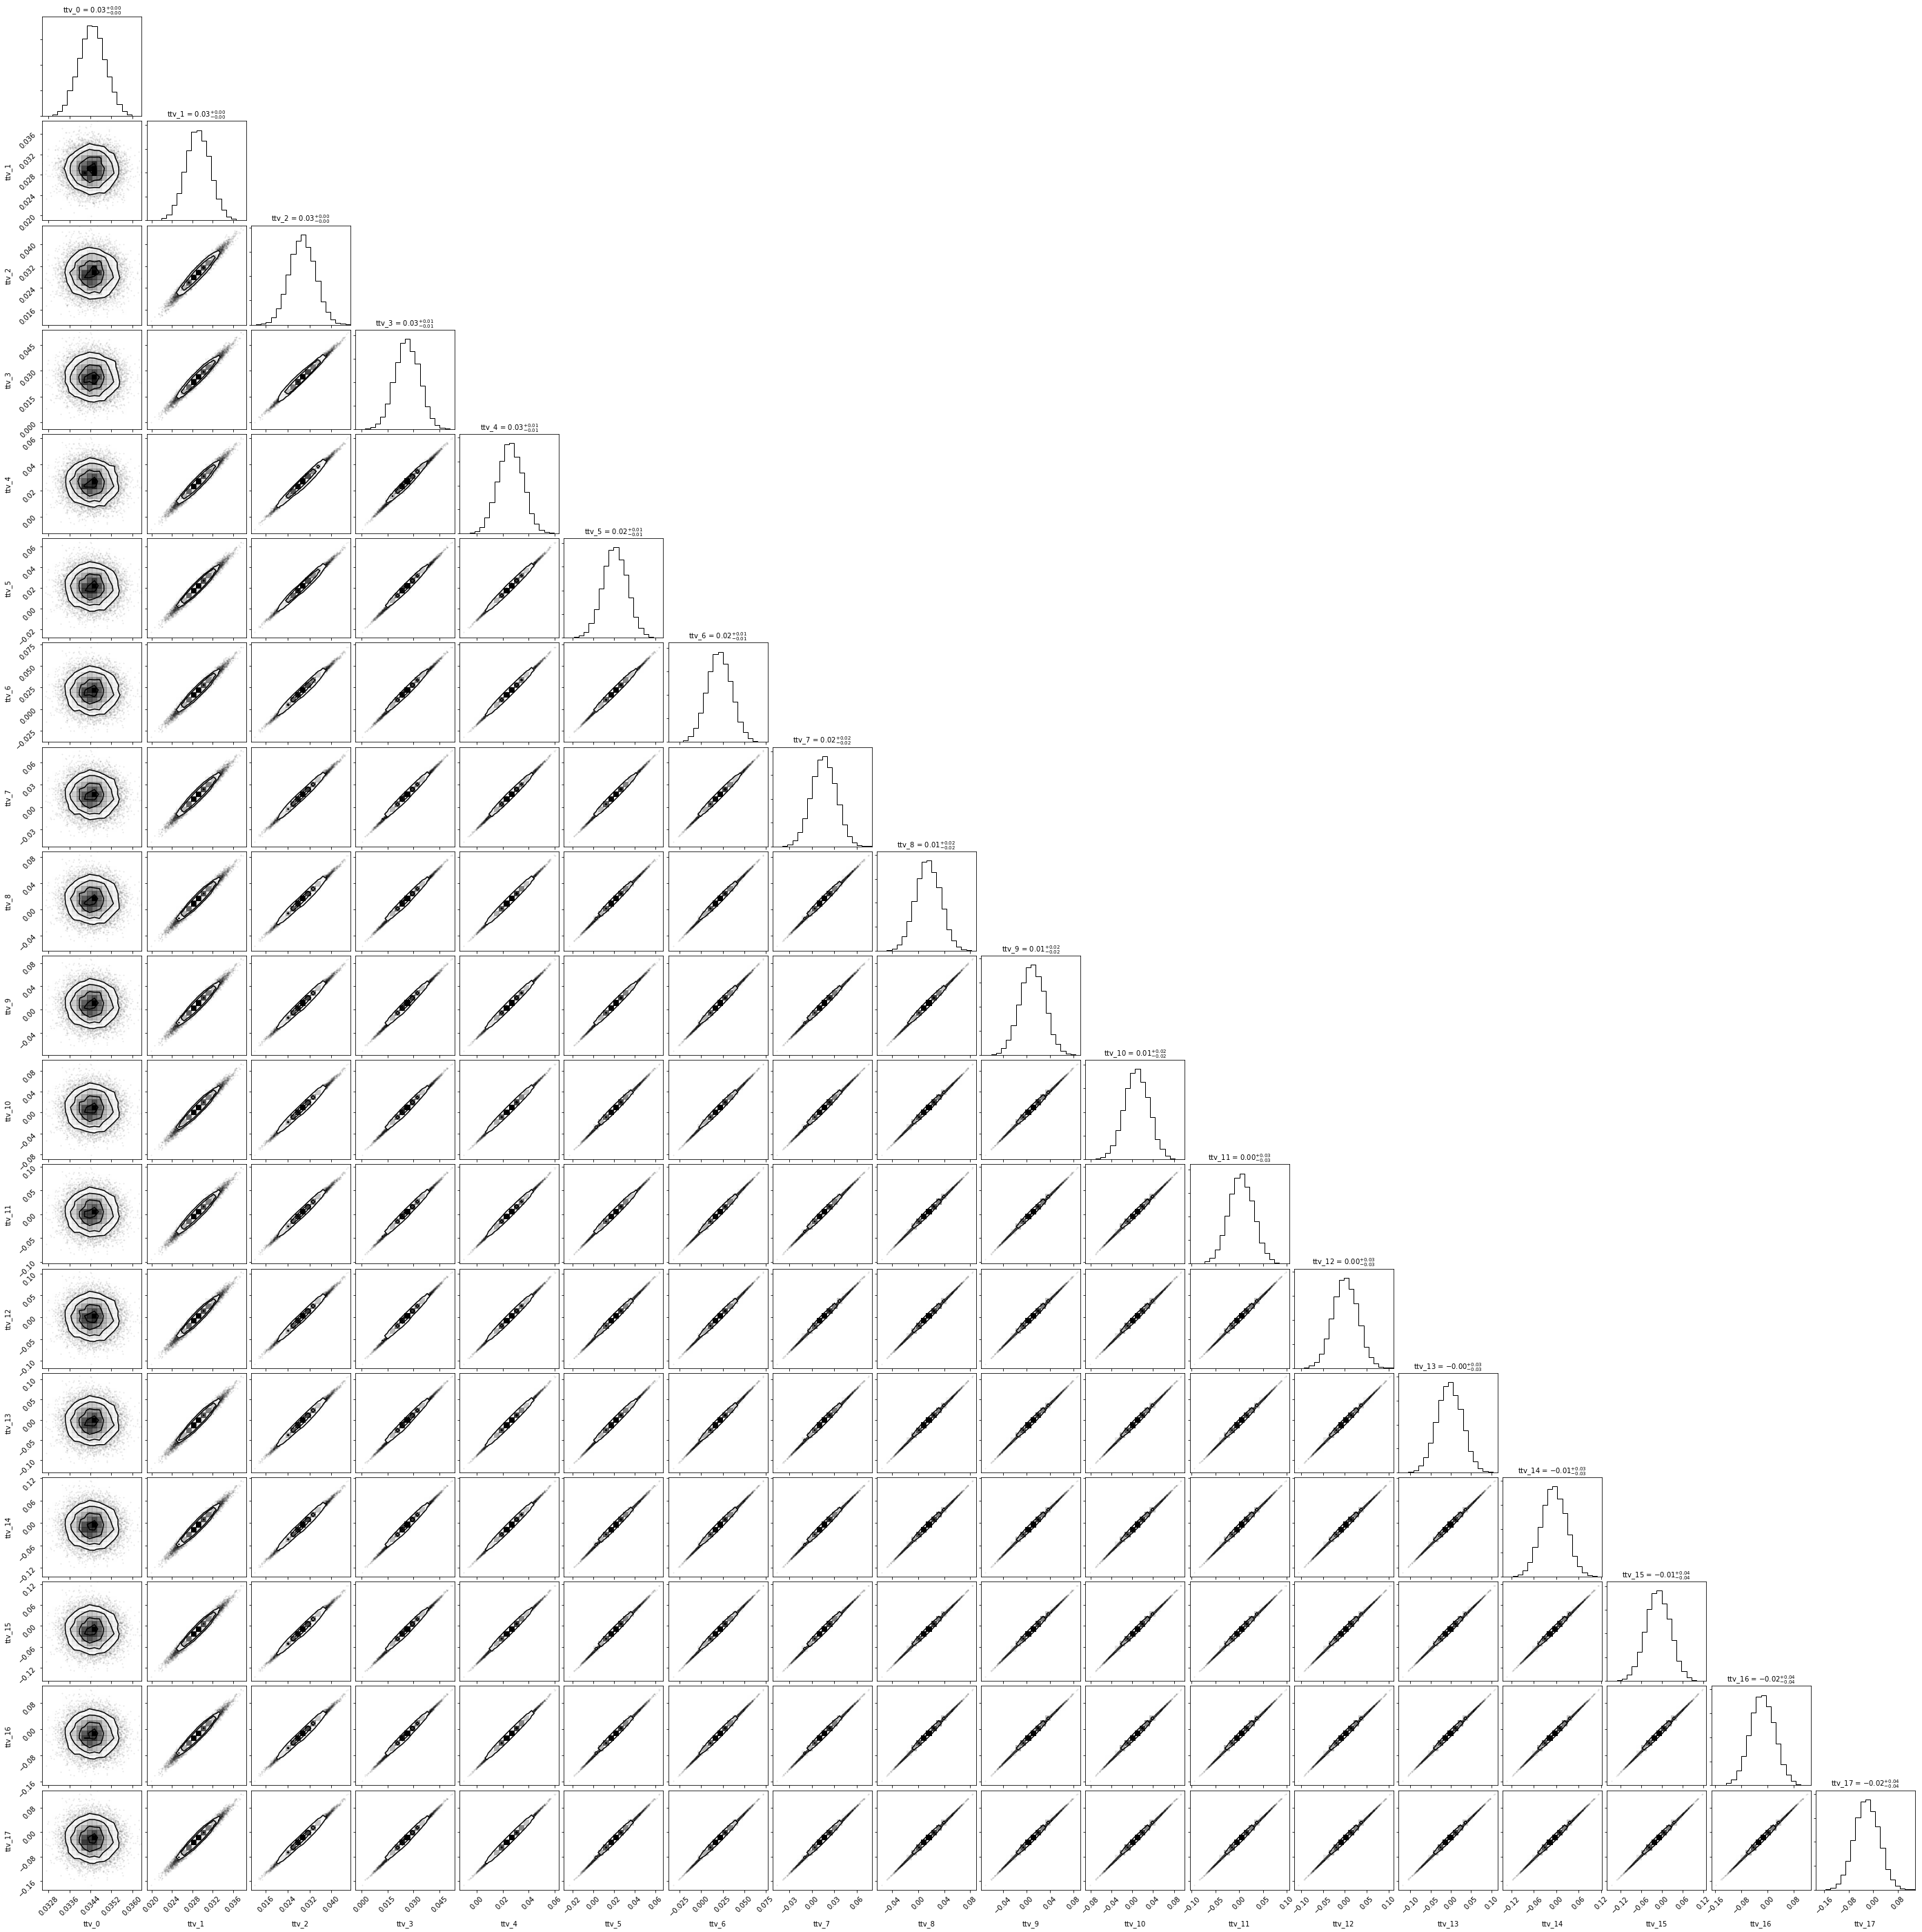

In [173]:
samples = []
labels = []

for name in vs:
    sample = np.array(trace[name])
    samples.append(sample.flatten())
    labels.append("{}".format(name))

samples = np.transpose(np.vstack(samples))
corner.corner(samples, labels=labels, show_titles=True, title_kwargs=dict(fontsize=10));